In [1]:
# libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py

import renom as rm
from renom import Sequential
from renom import Dense, Relu, BatchNormalize
from renom import Adam

In [2]:
searched_date='original'
df=pd.read_csv('intermediate_data/preprocessed_spec_iqr1_{}.csv'.format(searched_date))
df=df.drop(df.columns[0],axis=1)
df= df.astype('float')

In [3]:
df_s = df.copy()

col_std=[]
col_mean=[]
for col in df.columns:
    v_std = df[col].std()
    v_mean = df[col].mean()
    col_std.append(v_std)
    col_mean.append(v_mean)
    df_s[col] = (df_s[col] - v_mean) / v_std

df_s.head()

,price,平米単価,専有面積,間取り,築年数,構造,階数,向き,敷地の権利形態,管理費等,修繕積立金,取引態様,最寄り駅,駅からの手段,駅からの時間
0,0.251355,-0.377330,0.654635,0.551254,-0.315315,1.584285,0.219870,0.472656,-0.108301,-0.619355,0.831083,-0.190115,-0.385511,0.125534,-1.250363
1,-1.568916,-2.038864,-0.239313,-0.340654,2.017429,-0.635525,-0.317251,-0.077268,-0.108301,-0.841311,0.706445,-0.190115,0.512774,-7.965447,0.556232
2,-1.189493,-2.044015,2.337085,1.443161,0.957091,-0.635525,-0.854371,-0.077268,-0.108301,-1.134240,0.338387,-0.190115,-1.656111,-7.965447,1.007880
3,-0.228928,-0.838124,0.631155,0.551254,0.886402,1.584285,1.115071,-0.077268,-0.108301,-0.532351,-0.799247,-0.190115,0.536413,0.125534,0.330408
4,-0.320181,0.906848,-1.026107,-0.898096,-0.103247,-0.635525,-0.496291,-2.276963,-0.108301,0.240632,-0.281457,-0.190115,-1.567465,0.125534,-0.798714


In [4]:
X = df_s.drop('price', axis=1).as_matrix()
y = df_s['price']
indices=df.index

In [5]:
#データをわける
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, index_train,index_test = train_test_split(X, y,indices, test_size = 0.1, random_state = 666)

In [6]:
y_train=y_train.reshape(y_train.shape[0],-1)
y_test=y_test.reshape(y_test.shape[0],-1)

/Users/toshio/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/Users/toshio/py3env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [7]:
sequential = Sequential([
    Dense(15),
    Relu(),
    Dense(10),
    Relu(),
    Dense(8),
    Relu(),
    Dense(4),
    Relu(),
    Dense(1)
])

In [8]:
# parameters
BATCH = 30
EPOCH = 1500
optimizer = Adam(lr=0.01)

# Learning curves
learning_curve = []
test_curve = []

# Training loop
for i in range(1, 1+EPOCH):
    N = X_train.shape[0] # Number of records in training data
    perm = np.random.permutation(N)
    train_loss = 0

    for j in range(N//BATCH):
        # Make mini-batch
        index = perm[j*BATCH:(j+1)*BATCH]
        train_batch_x = X_train[index]
        train_batch_y = y_train[index]

        # Forward propagation
        with sequential.train():
            z = sequential(train_batch_x)
            loss = rm.mean_squared_error(z, train_batch_y)

        # Backpropagation
        grad = loss.grad()

        # Update
        grad.update(optimizer)

        train_loss += loss.as_ndarray()

    # calculate mean squared error for training data
    train_loss = train_loss / (N // BATCH)
    learning_curve.append(train_loss)

    # calculate mean squared error for testidation data
    y_test_pred = sequential(X_test)
    test_loss = rm.mean_squared_error(y_test_pred, y_test).as_ndarray()
    test_curve.append(test_loss)

    # print training progress
    if i % 10== 0:
        print("Epoch %d - loss: %f - test_loss: %f" % (i, train_loss, test_loss))

print('Finished!')

Epoch 10 - loss: 0.048320 - test_loss: 0.048878
Epoch 20 - loss: 0.048001 - test_loss: 0.049382
Epoch 30 - loss: 0.047805 - test_loss: 0.048175
Epoch 40 - loss: 0.047698 - test_loss: 0.048787
Epoch 50 - loss: 0.047858 - test_loss: 0.048449
Epoch 60 - loss: 0.047877 - test_loss: 0.047673
Epoch 70 - loss: 0.047658 - test_loss: 0.047691
Epoch 80 - loss: 0.047602 - test_loss: 0.048021
Epoch 90 - loss: 0.047534 - test_loss: 0.047570
Epoch 100 - loss: 0.047613 - test_loss: 0.047822
Epoch 110 - loss: 0.047596 - test_loss: 0.047501
Epoch 120 - loss: 0.047484 - test_loss: 0.047947
Epoch 130 - loss: 0.047274 - test_loss: 0.048152
Epoch 140 - loss: 0.047482 - test_loss: 0.048323
Epoch 150 - loss: 0.047612 - test_loss: 0.047835
Epoch 160 - loss: 0.047699 - test_loss: 0.047901
Epoch 170 - loss: 0.047535 - test_loss: 0.047686
Epoch 180 - loss: 0.047458 - test_loss: 0.047939
Epoch 190 - loss: 0.047477 - test_loss: 0.047428
Epoch 200 - loss: 0.047525 - test_loss: 0.048383
Epoch 210 - loss: 0.047456 - 

Epoch 1680 - loss: 0.047457 - test_loss: 0.048143
Epoch 1690 - loss: 0.047433 - test_loss: 0.048329
Epoch 1700 - loss: 0.047495 - test_loss: 0.048658
Epoch 1710 - loss: 0.047537 - test_loss: 0.048884
Epoch 1720 - loss: 0.047530 - test_loss: 0.048240
Epoch 1730 - loss: 0.047449 - test_loss: 0.048221
Epoch 1740 - loss: 0.047511 - test_loss: 0.048597
Epoch 1750 - loss: 0.047494 - test_loss: 0.048181
Epoch 1760 - loss: 0.047415 - test_loss: 0.048677
Epoch 1770 - loss: 0.047077 - test_loss: 0.048961
Epoch 1780 - loss: 0.047534 - test_loss: 0.048695
Epoch 1790 - loss: 0.047535 - test_loss: 0.049033
Epoch 1800 - loss: 0.047566 - test_loss: 0.048467
Epoch 1810 - loss: 0.047457 - test_loss: 0.048460
Epoch 1820 - loss: 0.047139 - test_loss: 0.048730
Epoch 1830 - loss: 0.047332 - test_loss: 0.048889
Epoch 1840 - loss: 0.047378 - test_loss: 0.048397
Epoch 1850 - loss: 0.047467 - test_loss: 0.048482
Epoch 1860 - loss: 0.047072 - test_loss: 0.048713
Epoch 1870 - loss: 0.047413 - test_loss: 0.048541


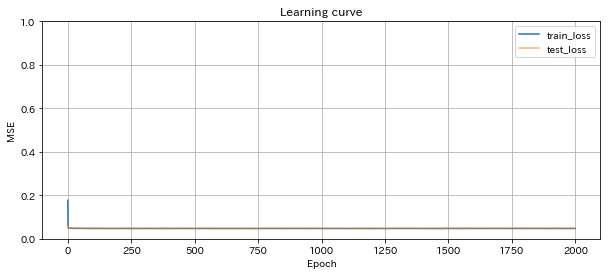

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(learning_curve, label='train_loss')
plt.plot(test_curve, label='test_loss', alpha=0.6)
plt.title('Learning curve')
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.ylim(0, 1)
plt.legend()
plt.grid()

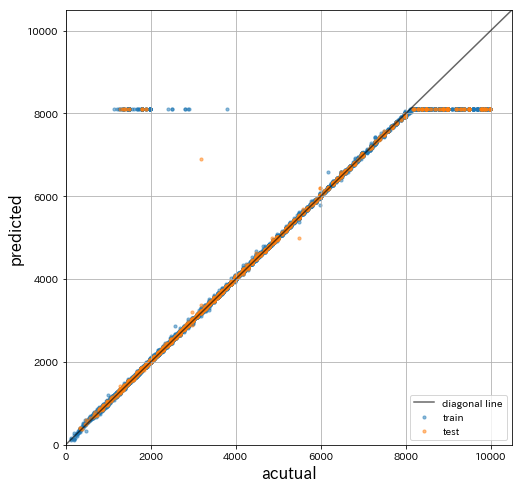

In [10]:
# predict test value
y_train_pred = sequential(X_train)
y_test_pred = sequential(X_test)

train_true = y_train[:,:1].reshape(-1, 1) * col_std[0] + col_mean[0]
train_pred = y_train_pred[:,:1] * col_std[0] + col_mean[0]
test_true = y_test[:,:1].reshape(-1, 1) * col_std[0] + col_mean[0]
test_pred = y_test_pred[:,:1] * col_std[0] + col_mean[0]

u_lim=10500
l_lim=0
plt.figure(figsize=(8, 8))
plt.plot([l_lim,u_lim], [l_lim,u_lim], c='k', alpha=0.6, label = 'diagonal line') # diagonal line
plt.scatter(train_true,train_pred,label='train',alpha=0.5,s=10)
plt.scatter(test_true,test_pred,label='test',alpha=0.5,s=10)
plt.xlim(l_lim,u_lim)
plt.ylim(l_lim,u_lim)
plt.xlabel('acutual', fontsize=16)
plt.ylabel('predicted', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [11]:
print("Root mean squared error:{}".format(np.sqrt(rm.mse(test_true,test_pred))))

Root mean squared error:457.259521484375


In [12]:
from sklearn.metrics import mean_squared_error
print('rmse_train=',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('rmse_test=',np.sqrt(mean_squared_error(y_test,y_test_pred)))
from sklearn.metrics import r2_score
print('r2_train=',r2_score(y_train,y_train_pred))
print('r2_test=',r2_score(y_test,y_test_pred))

rmse_train= 0.307651294912468
rmse_test= 0.31058089553736007
r2_train= 0.9054183209111395
r2_test= 0.9028462579266323


In [13]:
#モデルの保存
sequential.save("model/model_nn.h5_{}".format(searched_date))